# Sentinel Hub Feature Info Service (FIS)

<div class="alert alert-warning">

**Disclaimer:**
    
Sentinel Hub has a newer [Statistical API](https://docs.sentinel-hub.com/api/latest/api/statistical/) that replaces and extends functionalities of FIS service. We advise you to move to Statistical API and enjoy the full power of Sentinel Hub services. See the [notebook](./statistical_request.ipynb) with Statistical API examples.
</div>

One of the tools in `sentinelhub-py` package is a wrapper around Sentinel Hub **Feature Info Service (FIS)**. The service is documented at [Sentinel Hub webpage](https://www.sentinel-hub.com/develop/documentation/api/fis-request).

The main purpose of FIS service is to enable users obtaining statistics about satellite data without actually having to download large amounts of raster imagery. It is most effective when you have a sparse collection of bounding boxes or polygons spread over a large area and you would only like to know the aggregated values for each of them.

In order to use FIS it is required to have Sentinel Hub account and configured instance ID. For more about configuration details please check [prerequisites of notebook about WMS and WCS](https://sentinelhub-py.readthedocs.io/en/latest/examples/ogc_request.html#Prerequisites).

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from shapely.geometry import Polygon

from sentinelhub import FisRequest, BBox, Geometry, CRS, WcsRequest, CustomUrlParam, \
    DataCollection, HistogramType
from sentinelhub.time_utils import parse_time

Note that `pandas`, `seaborn` and `matplotlib` are not dependencies of `sentinelhub-py`, therefore you will have to install them manually.

## Prerequisites

For this functionality Sentinel Hub instance ID has to be configured according to the [instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html).

In [2]:
from sentinelhub import SHConfig

config = SHConfig()

if config.instance_id == '':
    print("Warning! To use FIS functionality, please configure the `instance_id`.")

## Exploring basic statistics

In the first example we will explore Sahara desert. There was a news about a sandstorm in March 2018 reported at [Earth Observatory webpage](https://earthobservatory.nasa.gov/images/91907/vast-dust-storms-in-the-sahara). By a quick search in EO Browser we can see the same sandstorm was also observed by Sentinel-2: [link](https://apps.sentinel-hub.com/eo-browser/?lat=25.205&lng=0.173&zoom=8&time=2018-03-21&preset=1_TRUE_COLOR&datasource=Sentinel-2%20L1C).

**Let's try to find out how to detect such sandstorm only by looking at some basic statistics of Sentinel-2 data.** With FIS we can do that without even downloading any image!

First we set our area of interest - the same part of Sahara desert in Algeria, where the sandstorm should be. For time interval we will take a period of 3 months around that time.

In [3]:
sahara_bbox = BBox((1.0, 26.0, 1.3, 25.7), CRS.WGS84)
time_interval = ('2018-02-01', '2018-05-01')

In order to obtain data from FIS service we first have to initialize `FisRequest` class. Just like `WmsRequest` or `WcsRequest` it belongs in the same family of `DataRequest` classes and therefore works in the same way.

We will set the following parameters:

* `layer` - name of the layer defined in Sentinel Hub Dashboard. In this case we will use the layer with all Sentinel-2 L1C bands,
* `geometry_list` - list of geometry objects (`BBox` or `Geometry`), statistics will be calculated for each of them separately,
* `time` - statistics will be calculated for each acquisition in the give time interval separately,
* `resolution` - spatial resolution on which to calculate statistics
* `data_folder` - optional parameter for specifying location where the data should be saved locally

In [4]:
fis_request = FisRequest(
    data_collection=DataCollection.SENTINEL2_L1C,
    layer='BANDS-S2-L1C',
    geometry_list=[sahara_bbox],
    time=time_interval,
    resolution='60m',
    data_folder='./data',
    config=config
)

The request can be executed by calling the standard `get_data` method. This will concurrently make calls to FIS for each geometry in the list and collect responses.

In [5]:
fis_data = fis_request.get_data(save_data=True)  # Takes about 30s, to avoid redownloading we are saving results

fis_data[0]['C0'][0]

{'date': '2018-04-30',
 'basicStats': {'min': 0.13920000195503235,
  'max': 0.27570000290870667,
  'mean': 0.16790866606430574,
  'stDev': 0.00859753310640891}}

The obtained data is a list of FIS responses for each geometry. Each response is a dictionary with statistics for each channel separately. In our case that is 13 channels, 1 for each Sentinel-2 band. Statistics is then further divided per each acquisition.

Let's parse this data into a `pandas` data frame.

In [6]:
def fis_data_to_dataframe(fis_data):
    """ Creates a DataFrame from list of FIS responses
    """
    COLUMNS = ['channel', 'date', 'min', 'max', 'mean', 'stDev']
    data = []
    
    for fis_response in fis_data:
        for channel, channel_stats in fis_response.items():
            for stat in channel_stats:
                row = [int(channel[1:]), parse_time(stat['date'], force_datetime=True)]
                
                for column in COLUMNS[2:]:
                    row.append(stat['basicStats'][column])
                
                data.append(row)
    
    return pd.DataFrame(data, columns=COLUMNS).sort_values(['channel', 'date'])


df = fis_data_to_dataframe(fis_data)

df.head()

,channel,date,min,max,mean,stDev
17,0,2018-02-04,0.1715,0.2577,0.185660,0.005714
16,0,2018-02-09,0.1478,0.2760,0.169501,0.007592
15,0,2018-02-14,0.1165,0.3047,0.170285,0.013389
14,0,2018-02-19,0.1327,0.2658,0.170829,0.015263
13,0,2018-02-24,0.4789,1.0189,0.730869,0.105041


The following code will plot timeseries of mean values (with standard deviation) for each band.

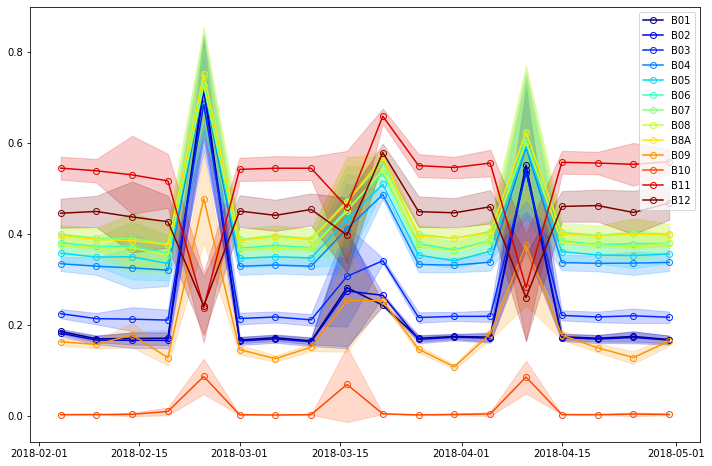

In [7]:
BANDS = 'B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12'.split(',')

plt.figure(figsize=(12, 8))
for channel, (band, color) in enumerate(zip(BANDS, cm.jet(np.linspace(0, 1, 13)))):
    channel_df = df[df.channel == channel]
    plt.plot(channel_df.date, channel_df['mean'], '-o', markeredgewidth=1,
             color=color, markerfacecolor='None', label=band)
    plt.fill_between(list(channel_df.date),  channel_df['mean'] - channel_df['stDev'],
                     channel_df['mean'] + channel_df['stDev'], alpha=0.2, color=color)

plt.legend(loc='upper right');

As there is no vegetation in the desert the reflectance values shouldn't change much over time. In our case it appears there are `4` acquisitions with different values that the rest - 5th, 9th, 10th and 14th acquisitions.

For all `4` acquisitions reflectance values are higher in visual spectra. However for 5th, 9th and 14th acquisition SWIR values (bands B11 and B12) are lover than average while for the 10th acquisition these values are higher than average. Hence this can lead us to conclusion that **5th, 9th and 14th acquisition contain clouds** while **10th acquisition is the one with the sandstorm**.

Just to be sure let's download true color images for these acquisitions and visually verify the results.

In [8]:
wcs_request = WcsRequest(
    data_collection=DataCollection.SENTINEL2_L1C,
    layer='TRUE-COLOR-S2-L1C',
    bbox= sahara_bbox,
    time=time_interval,
    resx='60m',
    resy='60m',
    custom_url_params={CustomUrlParam.SHOWLOGO: False},
    config=config
)

images = wcs_request.get_data()

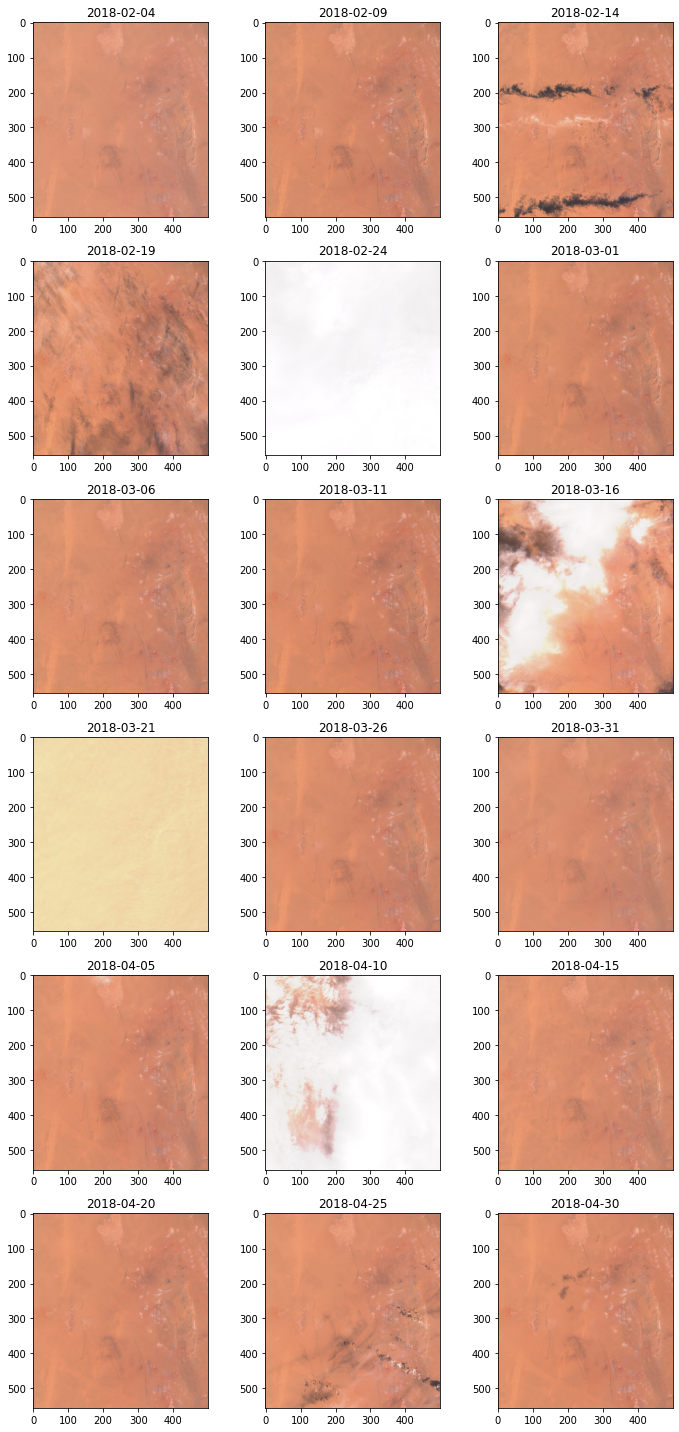

In [9]:
fig, axs = plt.subplots((len(images) + 2) // 3, 3, figsize=(10, 20))

for idx, (image, time) in enumerate(zip(images, wcs_request.get_dates())):
    axs.flat[idx].imshow(image)
    axs.flat[idx].set_title(time.date().isoformat())

fig.tight_layout()

##  Comparing histograms

Besides basic statistics FIS can also provide histograms of values split into specified number of bins. This allows us to analyze distribution of values without having to download entire images.

Let's compare NDVI value distributions of the following bounding boxes and polygons:

In [10]:
bbox1 = BBox([46.16, -16.15, 46.51, -15.58], CRS.WGS84)
bbox2 = BBox((1292344.0, 5195920.0, 1310615.0, 5214191.0), CRS.POP_WEB)

geometry1 = Geometry(Polygon([(-5.13, 48),
                              (-5.23, 48.09),
                              (-5.13, 48.17),
                              (-5.03, 48.08),
                              (-5.13, 48)]),
                     CRS.WGS84)
geometry2 = Geometry(Polygon([(1292344.0, 5205055.5),
                              (1301479.5, 5195920.0),
                              (1310615.0, 5205055.5),
                              (1301479.5, 5214191.0),
                              (1292344.0, 5205055.5)]),
                     CRS.POP_WEB)

Histogram can only be obtained by specifying parameter `bins`, which is the number of bins into which values should be divided. There are multiple ways of dividing values into bins currently supported:

In [11]:
list(HistogramType)

[<HistogramType.EQUALFREQUENCY: 'equalfrequency'>,
 <HistogramType.EQUIDISTANT: 'equidistant'>,
 <HistogramType.STREAMING: 'streaming'>]

In our case we will divide values into `20` bins and the size of each bin will be the same. We will use Landsat 8 data. For simplification we select such time interval that there is only `1` acquisition available.

In [12]:
ndvi_script = 'return [(B05 - B04) / (B05 + B04)]'

histogram_request = FisRequest(
    data_collection=DataCollection.LANDSAT_OT_L1,
    layer='TRUE-COLOR-L8',
    geometry_list=[bbox1, bbox2, geometry1, geometry2],
    time=('2018-06-10', '2018-06-15'),
    resolution='100m',
    bins=20,
    histogram_type=HistogramType.EQUIDISTANT,
    custom_url_params={CustomUrlParam.EVALSCRIPT: ndvi_script},
    config=config
)

histogram_data = histogram_request.get_data()

In [13]:
histogram_data[0]

{'C0': [{'date': '2018-06-14',
   'basicStats': {'min': -0.7464028596878052,
    'max': 0.8366492390632629,
    'mean': 0.1811648012698761,
    'stDev': 0.4241027442998325},
   'histogram': {'bins': [{'lowEdge': -0.7464028596878052, 'count': 15511.0},
     {'lowEdge': -0.6672502547502518, 'count': 17209.0},
     {'lowEdge': -0.5880976498126984, 'count': 6786.0},
     {'lowEdge': -0.5089450448751449, 'count': 3751.0},
     {'lowEdge': -0.42979243993759153, 'count': 1958.0},
     {'lowEdge': -0.35063983500003815, 'count': 2162.0},
     {'lowEdge': -0.2714872300624847, 'count': 2313.0},
     {'lowEdge': -0.19233462512493127, 'count': 2335.0},
     {'lowEdge': -0.11318202018737789, 'count': 2140.0},
     {'lowEdge': -0.0340294152498245, 'count': 2183.0},
     {'lowEdge': 0.04512318968772888, 'count': 3888.0},
     {'lowEdge': 0.12427579462528238, 'count': 9678.0},
     {'lowEdge': 0.20342839956283576, 'count': 17457.0},
     {'lowEdge': 0.28258100450038914, 'count': 44042.0},
     {'lowEdg

For each of the `4` areas we got back a FIS response. Each response contains statistics for NDVI channel and a single acquisition date. Besides basic statistics it also contains a histogram.

Let's plot them:

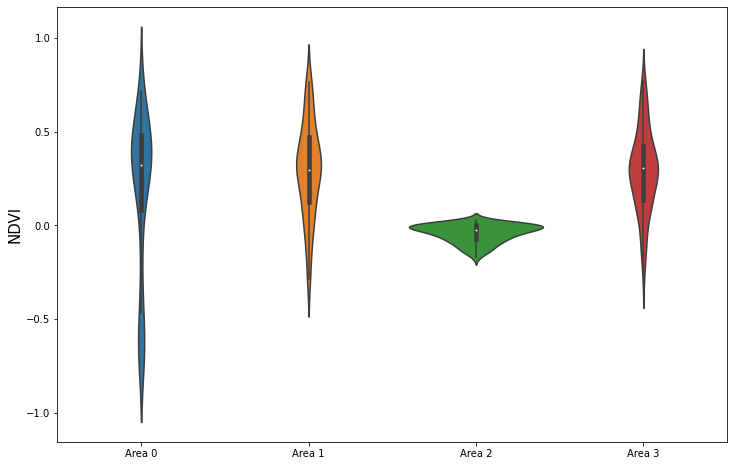

In [14]:
plot_data = []
for idx, fis_response in enumerate(histogram_data):
    bins = fis_response['C0'][0]['histogram']['bins']
    
    counts = [value['count'] for value in bins]
    total_counts = sum(counts)
    counts = [round(100 * count / total_counts) for count in counts]
    
    bin_size = bins[1]['lowEdge'] - bins[0]['lowEdge']
    splits = [value['lowEdge'] + bin_size / 2 for value in bins]
    
    data = []
    for count, split in zip(counts, splits):
        data.extend([split] * count)
    plot_data.append(np.array(data))
        
    
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.violinplot(data=plot_data, ax=ax)
ax.set(xticklabels=['Area {}'.format(idx) for idx in range(len(histogram_data))])
plt.ylabel('NDVI', fontsize=15);